In [1]:
from ime_pylib import scan_tools as sc

import matplotlib.pyplot as plt
import numpy as np
import sympy
import scipy as sp
from scipy.optimize import curve_fit

In [2]:
# sorted specific files that should be loaded into different folders
# as to not overload memory with useless data
sc.set_path("./IME_datfiles/empty")
res_e = sc.scan_load(623,700)
sc.set_path("./IME_datfiles/h2o/")
res_h2o = sc.scan_load(629,710)
sc.set_path("./IME_datfiles/d2o/")
res_d2o = sc.scan_load(646,700)
sc.set_path("./IME_datfiles/h2olipid/")
res_h2olip = sc.scan_load(650,720)
sc.set_path("./IME_datfiles/d2olipid/")
res_d2olip = sc.scan_load(655,720)
# Im sorry it prints this much, but you can just comment out the two lines in that read " else: print("No or multiple [...]" in scan_tools.py
res_h2olip

File: ./IME_datfiles/empty/MKA_000623.mat loaded . top_function: measure_c_bridge_lin (name identified from number)
File: ./IME_datfiles/empty/MKA_000688.mat loaded . top_function: measure_c_bridge_lin (name identified from number)
File: ./IME_datfiles/empty/MKA_000700.mat loaded . top_function: measure_c_bridge_lin (name identified from number)
File: ./IME_datfiles/h2o/MKA_000629.mat loaded . top_function: measure_c_bridge_lin (name identified from number)
File: ./IME_datfiles/h2o/MKA_000643.mat loaded . top_function: measure_c_bridge_lin (name identified from number)
File: ./IME_datfiles/h2o/MKA_000644.mat loaded . top_function: measure_c_bridge_lin (name identified from number)
File: ./IME_datfiles/d2o/MKA_000646.mat loaded . top_function: measure_c_bridge_lin (name identified from number)
File: ./IME_datfiles/d2o/MKA_000647.mat loaded . top_function: measure_c_bridge_lin (name identified from number)
File: ./IME_datfiles/d2o/MKA_000698.mat loaded . top_function: measure_c_bridge_li

In [3]:
# generic empty resonance frequency equation
def model(f, Ccl, Cfr, f0, Q):
    x = f/f0
    return Ccl + (Cfr-Ccl)/(1 - x**2 + 1j*x/Q)

# curve fits by least-square integration to given model, starting from p0
def fit(var_model, fdata, ydata, p0):
    
    def fit_func(fdata, *args):
        m = var_model(fdata, *args)
        return np.abs(m)
    
    ydata_real = np.abs(ydata)
    popt, _ = curve_fit(fit_func, fdata, ydata_real, p0)
    return popt

# 
def makefits(var_model, data, p0, S=0, s=900, e=1200):
    
    if var_model == model:
        data_fit = np.zeros((len(data),4000), dtype=complex)
        popt_data = np.zeros((len(data),len(p0)))
    
        for i in range(0, len(data)):
            # find values for parameters
            popt_data[i] = fit(model, data[i].fr_bridge, data[i].C_bridge, p0)

            # the model sometimes comes up with negative values for a parameter
            # Since we know they are all positive, this always corrects that
            popt_data[i] = np.abs(popt_data[i])

            # find the ydata for the fit to plot it later
            data_fit[i] = model(data[i].fr_bridge, *popt_data[i])
            
            p0= popt_data[i]

        return data_fit, popt_data
    
    if var_model == stiffmodel:
        data_fit = np.zeros((len(data),4000), dtype=complex)
        popt_data = np.zeros((len(data),len(p0[0])))
        for i in range(0, len(data)):
            # find values for parameters
            # s and e are used as starting and ending points for fits as fits the entire range are completely useless
            popt_data[i] = fit(stiffmodel, data[i].fr_bridge[s:e], S[i][s:e], p0[i])

            # the model sometimes comes up with negative values for a parameter
            # Since we know they are all positive, this always corrects that
            popt_data[i] = np.abs(popt_data[i])

            # find the ydata for the fit to plot it later
            data_fit[i] = stiffmodel(data[i].fr_bridge, *popt_data[i])
        
        return data_fit, popt_data
    
    if var_model == filledmodel:
        data_fit = np.zeros((len(data),4000), dtype=complex)
        popt_data = np.zeros((len(data),len(p0[0])))
        for i in range(0, len(data)):
            # find values for parameters
            popt_data[i] = fit(filledmodel, data[i].fr_bridge, data[i].C_bridge, p0[i])

            # the model sometimes comes up with negative values for a parameter
            # Since we know they are all positive, this always corrects that
            popt_data[i] = np.abs(popt_data[i])

            # find the ydata for the fit to plot it later
            data_fit[i] = filledmodel(data[i].fr_bridge, *popt_data[i])
        
        return data_fit, popt_data
    
    if var_model == lineuptoC:
        data_fit = np.zeros((len(data),4000), dtype=complex)
        popt_data = np.zeros((len(data),len(p0[0])))
        for i in range(0, len(data)):
            # find values for parameters
            popt_data[i] = fit(lineuptoC, data[i].fr_bridge, data[i].C_bridge, p0[i])

            # the model sometimes comes up with negative values for a parameter
            # Since we know they are all positive, this always corrects that
            popt_data[i] = np.abs(popt_data[i])

            # find the ydata for the fit to plot it later
            data_fit[i] = lineuptoC(data[i].fr_bridge, *popt_data[i])
        
        return data_fit, popt_data
    
    raise ValueError("this function can not fit data to the model ", var_model)

In [4]:
Ccl_0 = 1.7e-8
Cfr_0 = 2e-8
f0_0 = 9.3e4
Q_0 = 100

p0 = Ccl_0, Cfr_0, f0_0, Q_0
Cfit_e, popt_C_e = makefits(model, res_e, p0)
Cfit_h2o, popt_C_h2o = makefits(model, res_h2o, p0)
Cfit_d2o, popt_C_d2o = makefits(model, res_d2o, p0)
Cfit_d2olip, popt_C_d2olip = makefits(model, res_d2olip, p0)
#Cfit_h2olip, popt_C_h2olip = makefits(model, res_h2olip, p0)
popt_C_d2o

array([[1.75914910e-08, 1.94994636e-08, 8.45035715e+04, 1.53222233e+02],
       [1.75894412e-08, 1.94962238e-08, 8.44975621e+04, 1.64114510e+02],
       [1.83461024e-08, 2.02928972e-08, 8.60382387e+04, 4.10124434e+02]])

In [5]:
ccycle = ['b', 'r', 'g', 'm', 'k', 'c']
def plotfigs(data, fit, *line, size=(8,6), imag = False, compare=False, alpha=1, xlim=(0,4e5), logscale=False, ylim=(0,0)):
    
    plt.figure(figsize = size)
    for i in range(len(data)):
        if compare == True:
            alpha = 0.6
            plt.plot(data[i].fr_bridge, data[i].C_bridge.real, ls='dotted', c= ccycle[i])
        plt.plot(data[i].fr_bridge, fit[i].real, ls='-',c = ccycle[i], alpha=alpha)
    
    for arg in line:
        if  arg[0] == 'x':
            plt.axvline(arg[1], linestyle=':', color='k')
        else:
            plt.axhline(arg[1], linestyle=':', color='k')
    plt.xlim(xlim)
    if logscale == True:
        plt.xscale('log')
    if ylim != (0,0):
        plt.ylim(ylim)
    plt.show()
        
    plt.figure(figsize = size)
    if imag == True:
        for i in range(len(data)):
            if compare == True:
                alpha = 0.6
                plt.plot(data[i].fr_bridge, data[i].C_bridge.imag, ls ='dotted', c=ccycle[i])
            plt.plot(data[i].fr_bridge, fit[i].imag, ls='-', c= ccycle[i], alpha=alpha)
        for arg in line:
            if arg[0] == 'x':
                plt.axvline(arg[1], linestyle=':', color='k')
            else:
                plt.axhline(arg[1], linestyle=':', color='k')
        plt.xlim(xlim)
        if logscale == True:
            plt.xscale('log')
        if ylim != (0,0):
            plt.ylim(ylim)
        plt.show()

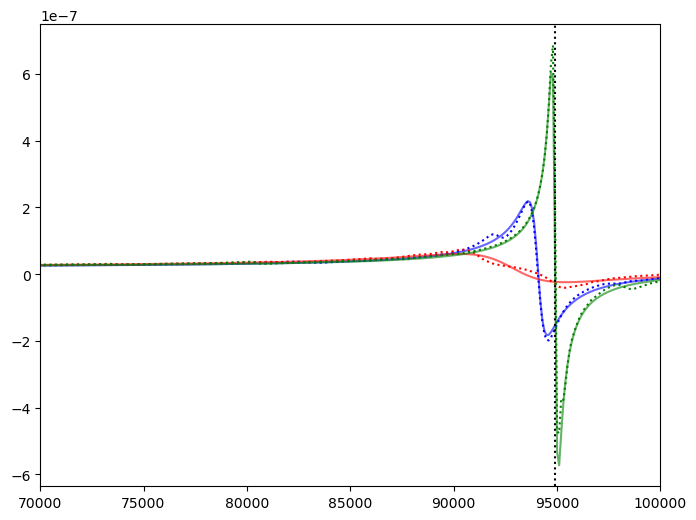

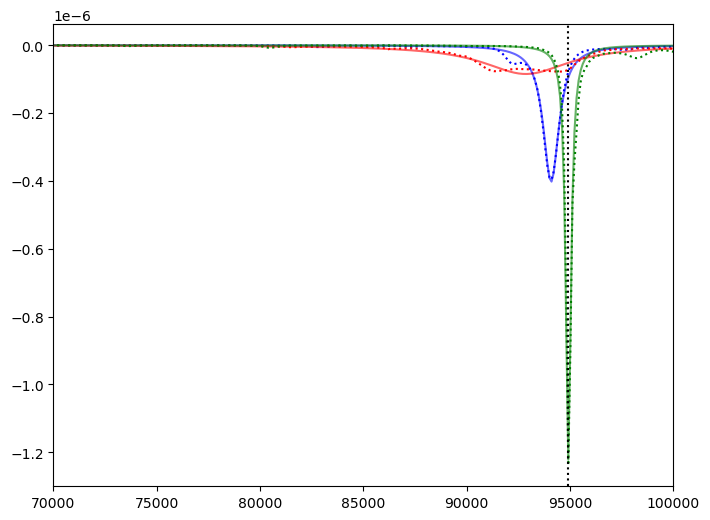

In [6]:
#plt.rc('font', size=12)
plotfigs(res_e, Cfit_e, ('x', popt_C_e[2][2]), compare=True, xlim = (7e4,1e5),imag=True)

## normalize capacitance

$$F(f) = \frac{C_m(f) - C_{cl}}{C_{fr} - C_{cl}}$$

In [7]:
def normcap(Cm,Ccl,Cfr):
    return (Cm - Ccl)/(Cfr - Ccl)

def normloop(data, popt):
    F = np.zeros_like(data)
    for i in range(0, len(data)):
        F[i] = normcap(data[i].C_bridge, popt[i][0], popt[i][1])
    return F

In [8]:
F_e = normloop(res_e, popt_C_e)
F_h2o = normloop(res_h2o, popt_C_h2o)
F_d2o = normloop(res_d2o, popt_C_d2o)
F_d2olip = normloop(res_d2olip, popt_C_d2olip)
#F_h2olip = normloop(res_h2olip, popt_C_h2olip)

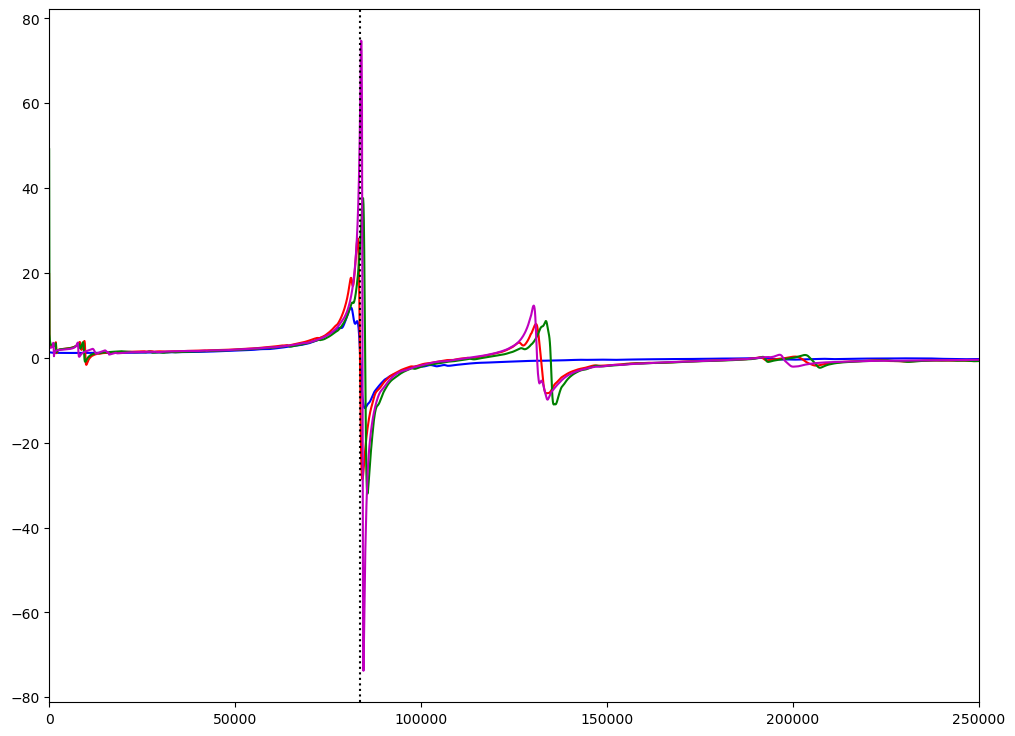

(0.0, 250000.0)

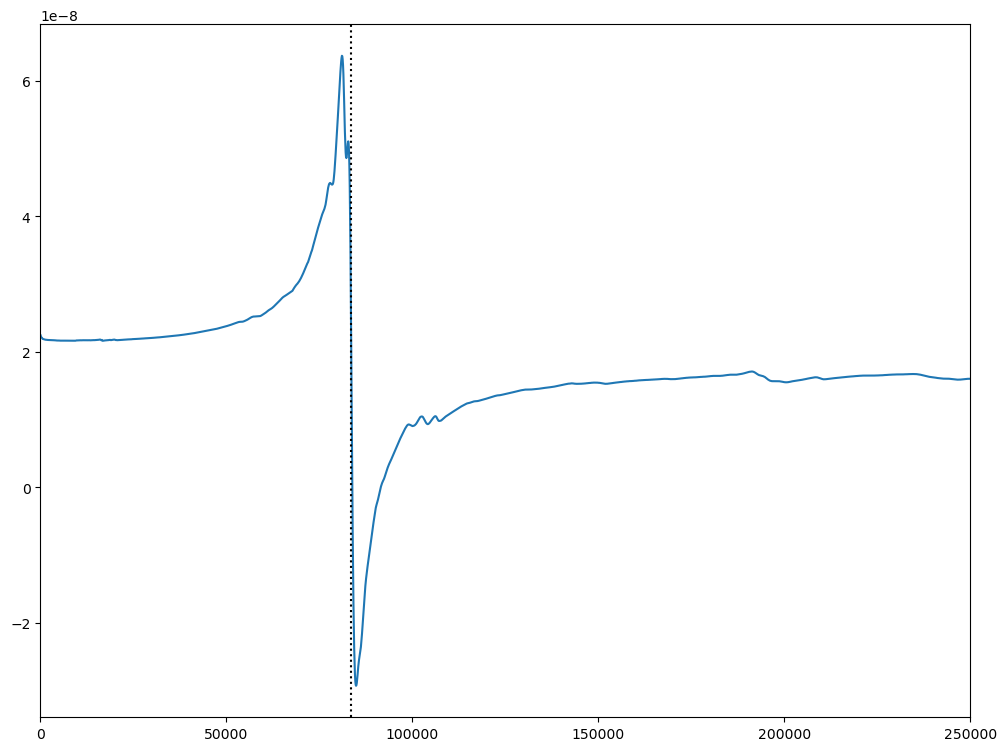

In [9]:
plotfigs(res_d2olip, F_d2olip, ('x', popt_C_d2olip[0][2]), size = (12,9), xlim=(0,2.5e5))
# for reference
plt.plot(res_d2olip[0].fr_bridge, res_d2olip[0].C_bridge.real)
plt.axvline(popt_C_d2olip[0][2], ls=':', c='k')
plt.xlim(0,2.5e5)

## stiffness+bulk modulus

$$S_{\mathrm{liq}} = L \omega_0^2 \left( \frac{1}{F(\omega)} - 1 + \left( \frac{\omega}{\omega_0} \right)^2 - i \frac{\omega}{\omega_0} \frac{1}{Q} \right)$$

In [10]:
def stiffness(f, f0, Q, F, L):
    return L*((2*np.pi*f0)**2)*((1/F) - 1 + (f/f0)**2 - 1j*(f/f0)*(1/Q))

def stiffloop(data, popt, F, L):
    S = np.zeros_like(data)

    for i in range(0,len(data)):
        S[i] = stiffness(data[i].fr_bridge, popt[i][2], popt[i][3], F[i], L)
    return S

In [11]:
m = 0.005
r0 = 0.01
L = m/(4*np.pi*(r0**2))**2
V = (4/3)*np.pi*(r0**3)

S_e = stiffloop(res_e, popt_C_e, F_e, L)
S_h2o = stiffloop(res_h2o, popt_C_h2o, F_h2o, L)
S_d2o = stiffloop(res_d2o, popt_C_d2o, F_d2o, L)
S_d2olip = stiffloop(res_d2olip, popt_C_d2olip, F_d2olip, L)
#S_h2olip = stiffloop(res_h2olip, popt_C_h2olip, F_h2olip, L)

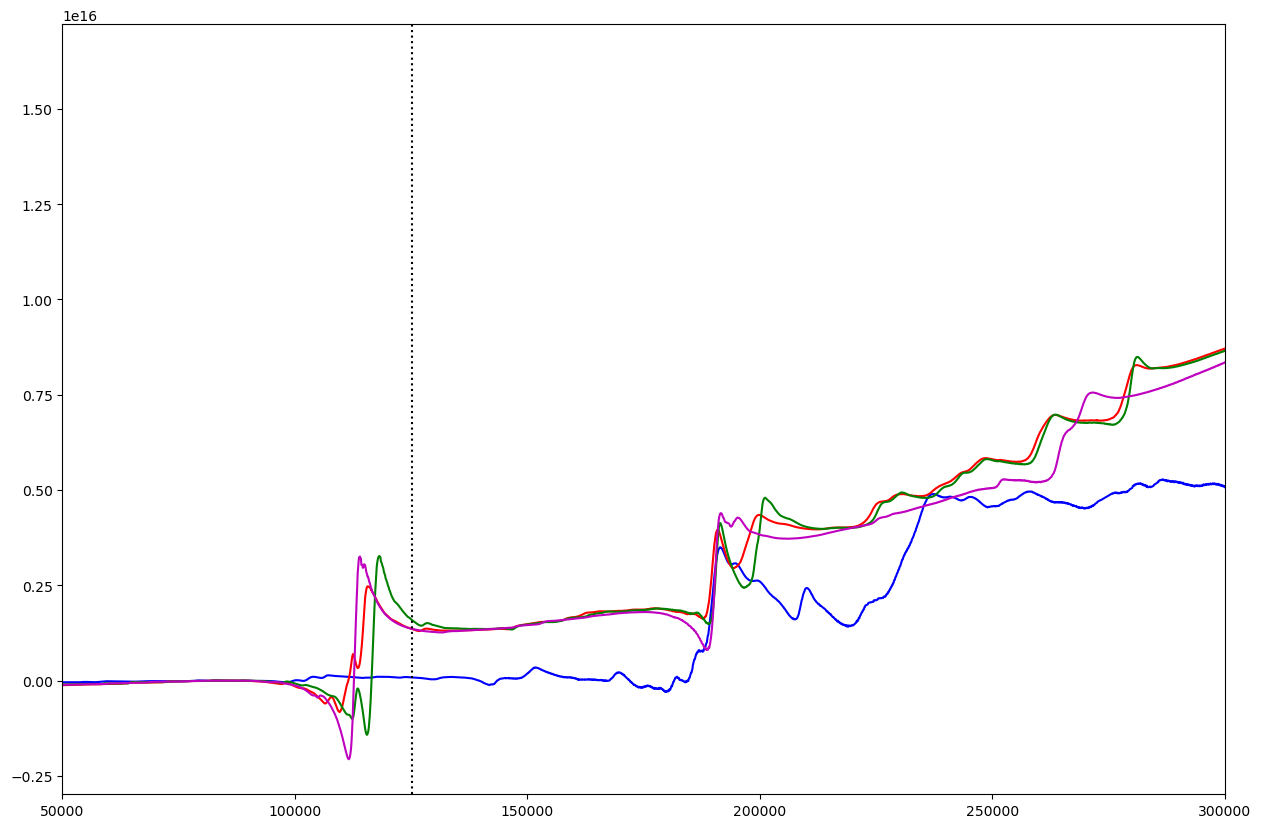

/home/user00/Programs/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(50000.0, 300000.0)

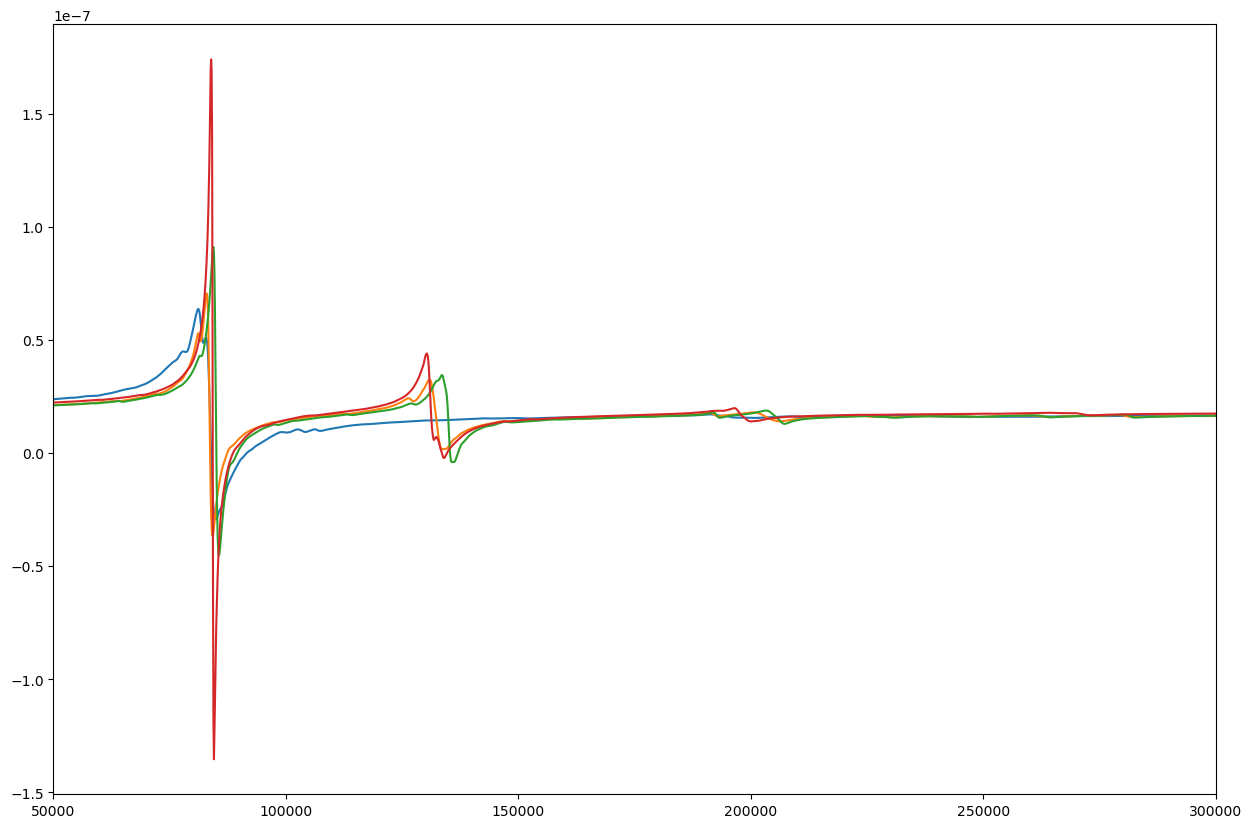

In [12]:
#plt.ylim(0e9, 4e9)
plotfigs(res_d2olip, S_d2olip,('x', res_d2olip[0].fr_bridge[1250]), xlim=(5e4, 3e5), size=(15,10))
# for reference
for i in range(len(res_d2olip)):
    plt.plot(res_d2olip[i].fr_bridge, res_d2olip[i].C_bridge)
plt.xlim(5e4,3e5)

### $S_{liq}(\omega)=\frac{1}{V}\left(K_S-\frac{1}{15}\rho \omega ^2r_0^2\right)$

In [13]:
def quasistatic(f, Ks, rho, r=0.01, V = (4/3)*np.pi*(0.01**3)):
    omega = np.pi*2*f
    return 1/V*(Ks-1/15*rho*omega**2*r**2)

$$ \omega_{res} : 1-\left(\frac{\omega}{\omega_0}\right)^2+\frac{K}{V}g\left(\frac{\omega}{\omega_c}\right) = 0$$

$$g(x) = -\frac{1}{3} \frac{x^2 \sin x}{x \cos x - \sin x} \ ,\ \omega_c = \sqrt{ \frac{K}{\rho} } \frac{1}{r}$$

In [14]:
def lineuptoC(f, Cfr, K, fc, Q, f0=popt_C_e[2][2], Ccl = popt_C_e[2][0]):
    xc = f/fc
    x0 = f/f0
    return 1 - x0**2 + 1j*x0/Q + (Cfr-Ccl)*(-K/(3*np.pi*0.01**3))*(xc**2*np.sin(xc))/(xc * np.cos(xc) - np.sin(xc))

In [15]:
p0_d2o_0 = [1.6e-08, 1.5e+01, 1.88e+04,]
p0_d2o_1 = [1.6e-08, 1.5e+01, 1.88e+04,]
p0_d2o_2 = [1.8e-08, 1.5e+01, 1.92e+04,]

p0_h2o_0 = [1.8e-08, 1.5e+01, 1.965e+04]
p0_h2o_1 = [1.8e-08, 1.5e+01, 1.967e+04]
p0_h2o_2 = [1.8e-08, 1.5e+01, 1.967e+04]

p0_d2olip_0 = [1.8e-08, 1.5e+01, 1.86e+04]
p0_d2olip_1 = [1.8e-08, 1.5e+01, 1.865e+04]
p0_d2olip_2 = [1.8e-08, 1.5e+01, 1.9e+04]
p0_d2olip_3 = [1.8e-08, 1.5e+01, 1.89e+04]

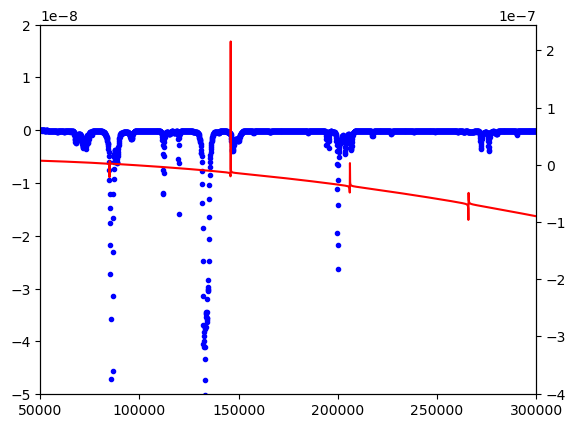

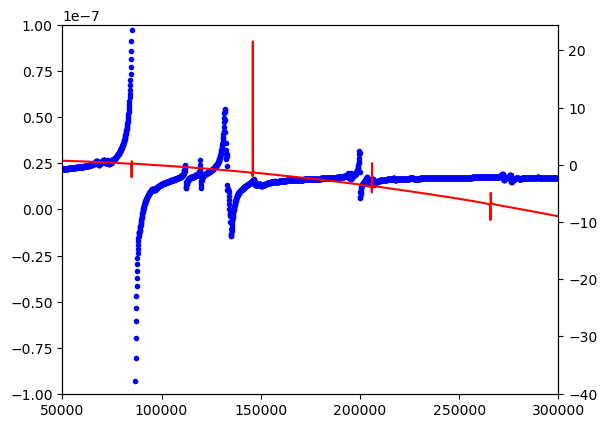

In [18]:
data = res_d2o
i = 2
p0 = p0_d2olip_3 = [1.8e-08, 1.5e+01, 1.89e+04, 2.89948517e+13]

data_fit = np.zeros((1,4000), dtype=complex)
data_fit = lineuptoC(data[i].fr_bridge, *p0)

data_fit_imag = data_fit*1j*1e-8
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(data[i].fr_bridge, data[i].C_bridge.imag, '.b')
ax2.plot(data[i].fr_bridge, data_fit_imag.imag, '-r')
ax1.set_ylim(-5e-8,2e-8)
ax1.set_xlim(5e4,3e5)
#plt.ylim(-1,2e-7)
plt.show()

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(data[i].fr_bridge, data[i].C_bridge.real, '.b')
ax2.plot(data[i].fr_bridge, data_fit.real, '-r')
ax1.set_ylim(-1e-7,1e-7)
ax1.set_xlim(5e4,3e5)
#plt.ylim(-1,2e-7)
plt.show()

In [17]:
p0 =   [[popt_C_e[0][1], 1200000, 14300, popt_C_e[0][3]], [popt_C_e[1][1], 1200000, 14300, popt_C_e[1][3]], [popt_C_e[2][1], 1400000, 18400, popt_C_e[2][3]]]
S_fit_e, popt_S_e = makefits(lineuptoC, res_e, p0)

p0 = [[popt_C_h2o[0][1], 2.1e9, 2.7e4, popt_C_h2o[0][3]], [popt_C_h2o[1][1], 2.1e9, 2.7e4, popt_C_h2o[0][3]], [popt_C_h2o[2][1], 2.1e9, 2.7e4, popt_C_h2o[2][3]]]
S_fit_h2o, popt_S_h2o = makefits(lineuptoC, res_h2o, p0)

p0 = [[popt_C_d2o[0][1], 2.3e8, 2.55e4, popt_C_d2o[0][3]], [popt_C_d2o[1][1], 2.3e8, 2.55e4, popt_C_d2o[1][3]], [popt_C_d2o[2][1], 2.3e8, 2.55e4, popt_C_d2o[2][3]]]
S_fit_d2o, popt_S_d2o = makefits(lineuptoC, res_d2o, p0, S=S_d2o, s=900, e=1800)

p0 = [[popt_C_d2olip[0][1], 2e8, 4.2e4, popt_C_d2olip[0][3]], [popt_C_d2olip[1][1], 2e8, 2.46e4, popt_C_d2olip[1][3]], [popt_C_d2olip[2][1], 2e8, 2.57e4, popt_C_d2olip[2][3]], [popt_C_d2olip[3][1], 2e8, 2.48e4, popt_C_d2olip[3][3]]]
S_fit_d2olip, popt_S_d2olip = makefits(lineuptoC, res_d2olip, p0, S=S_d2olip, s=1140, e=1950)

NameError: name 'stiffmodel' is not defined

In [ ]:
i =0
plt.plot(res_d2o[i].fr_bridge, res_d2o[i].C_bridge.real, '.')
plt.plot(res_d2o[i].fr_bridge, S_fit_d2o[i].real, ls='-')
plt.ylim(-2e-7,2e-7)
plt.xlim(5e4,3e5)
#plt.ylim(-1,2e-7)
plt.show()

plt.plot(res_d2o[i].fr_bridge, res_d2o[i].C_bridge.imag, '.')
plt.plot(res_d2o[i].fr_bridge, S_fit_d2o[i].imag, ls='-')
plt.ylim(-2e-7,2e-7)
plt.xlim(5e4,3e5)
#plt.ylim(-1,2e-7)

## function for fitting stiffness stuff

$$\frac{1}{C_{liq}(\omega)} =S_{liq}(\omega) = \frac{K}{V} g\left( \frac{\omega}{\omega_c} \right) \mathrm{where}\  g(x) = -\frac{1}{3} \frac{x^2 \sin x}{x \cos x - \sin x} \ ,\ \omega_c = \sqrt{ \frac{K}{\rho} } \frac{1}{r}$$

$$ \Rightarrow S(\omega) = - \frac{K}{4*\pi*r^3}\frac{ x^2 \sin (x)}{x \cos (x) - \sin (x)}\ ,\ x=\frac{\omega}{\omega_c} = \frac{\omega}{\sqrt{K/\rho}} *r $$


In [ ]:
# define stiffness
def stiffmodel(f, K, fc):
    x = f/fc
    return (-1/(4*np.pi*(0.01)**3))*(K*((x**2)*np.sin(x))/(x * np.cos(x) - np.sin(x)))

In [ ]:
'''
Hey, this is where it gets problematic.
I *believe* we should fit the equation, 'stiffmodel', above to the Stiffness curve, which we got from 'stiffness'.
For that we throw what you see below to 'makefits' in cell 3, which calls on 'fit' (also cell 3) to make all values real
and thus comprehensible for the curve_fit imported from scipy.optimize.
I dont know if you need it but this is the documentation on curve_fit:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html
'''

p0 =   [[1200000, 14300], [1200000, 14300], [1400000, 18400]]
S_fit_e, popt_S_e = makefits(stiffmodel, res_e, p0, S=S_e, s=2075, e=2800)

p0 = [[2.1e9, 2.7e4], [2.1e9, 2.7e4], [2.1e9, 2.7e4]]
S_fit_h2o, popt_S_h2o = makefits(stiffmodel, res_h2o, p0, S=S_h2o, s=900, e=1600)

p0 = [[2.3e8, 2.55e4], [2.3e8, 2.55e4], [2.3e8, 2.55e4]]
S_fit_d2o, popt_S_d2o = makefits(stiffmodel, res_d2o, p0, S=S_d2o, s=900, e=1800)

p0 = [[2e8, 4.2e4], [2e8, 2.46e4], [2e8, 2.57e4], [2e8, 2.48e4]]
S_fit_d2olip, popt_S_d2olip = makefits(stiffmodel, res_d2olip, p0, S=S_d2olip, s=1140, e=1950)

#p0 = 8e8, 1.2e4
#S_fit_h2olip, popt_S_h2olip = makefits(stiffmodel, res_h2olip, p0, S=S_h2olip, s=840, e=1250)

In [ ]:
def drawScomparison(data, S, S_fit):
    for i in range(len(data)):
        plt.plot(data[i].fr_bridge, S_fit[i], ls='dotted', c=ccycle[i])
        plt.plot(data[i].fr_bridge, S[i], ls='-', c=ccycle[i])
    plt.axvline(data[0].fr_bridge[2075], linestyle=':', color='k')
    plt.axvline(data[0].fr_bridge[2800], linestyle=':', color='k')
    #plt.xlim(8e4,)
    plt.xlim(0,3e5)
    plt.ylim(-5e15,1e16)
    #plt.ylim(-3e15, 3e15)
    #plt.xscale('log')
    plt.show()

In [ ]:
plt.figure(figsize=(10,8))
drawScomparison(res_e, S_e, S_fit_e)
plt.figure(figsize=(10,8))
drawScomparison(res_d2o, S_d2o, S_fit_d2o)
#plotfigs(res_h2o, S_fit_h2o, ('x', res_h2o[0].fr_bridge[900]), ('x',res_h2o[0].fr_bridge[1200]), xlim=(0,4e5), ylim =(-5e15,1e16))

In [ ]:
'''
This is a cell to alter the parameters by hand and find something that vaguely fits
'''
i=3
p0 = [[2e8, 4.2e4], [2e8, 2.46e4], [2e8, 2.57e4], [2e8, 2.48e4]]
S_fit_d2olip[i] = stiffmodel(res_d2olip[i].fr_bridge, *p0[i])

plt.figure(figsize=(14,8))

plt.plot(res_d2olip[i].fr_bridge, S_d2olip[i])
plt.plot(res_d2olip[i].fr_bridge, S_fit_d2olip[i])

plt.xlim(0,3e5)
plt.ylim(-5e15,1e16)

In [ ]:
def filledmodel(f, Ccl, Cfr, f0, Q, K, fc, L=.005/(4*np.pi*(r0**2))**2):
    x = f/f0
    S = stiffmodel(f, K, fc)
    return Ccl + (Cfr-Ccl)/(1 - x*x + 1j*x/Q + S/(L*(2*np.pi*f0)**2))

def filledloop(data, popt_C, popt_S, L):
    C_fit = np.zeros_like(data)
    for i in range(len(data)):
        C_fit[i] = filledmodel(data[i].fr_bridge, *popt_C[i], *popt_S[i], L)
    return C_fit

In [ ]:
C_e = filledloop(res_e, popt_C_e, popt_S_e, L)
C_h2o = filledloop(res_h2o, popt_C_h2o, popt_S_h2o, L)
C_d2o = filledloop(res_d2o, popt_C_d2o, popt_S_d2o, L)
C_d2olip = filledloop(res_d2olip, popt_C_d2olip, popt_S_d2olip, L)
#C_h2olip = filledloop(res_h2olip, popt_C_h2olip, popt_S_h2olip, L)
#Cwater = filledmodel(res[10].fr_bridge, popt[10][0], popt[10][1], popt[10][2], popt[10][3], popt_Swater[0], popt_Swater[1], L)
np.shape(C_e[0])

In [ ]:
#plt.plot(res[10].fr_bridge, np.real(res[10].C_bridge), '.r')
#plt.plot(res[10].fr_bridge, np.real(Cwater), '-b', alpha =.7) 

plotfigs(res_e, C_e, compare=True, xlim=(0,2.5e5), ylim=(-1e-7,1e-7))
plotfigs(res_h2o, C_h2o, compare=True, xlim=(0,2.5e5), ylim=(-1e-7,1e-7))
plotfigs(res_d2o, C_d2o, compare=True, xlim=(0,2.5e5), ylim=(-1e-7,1e-7))
plotfigs(res_d2olip, C_d2olip, compare=True, xlim=(0,2.5e5), ylim=(-1e-7,1e-7))
#plotfigs(res_h2olip, C_h2olip, compare=True, xlim=(0,2.5e5), ylim=(-1e-7,1e-7))
#plt.xlim(0,2.5e5)
#plt.ylim(-1e-7,1e-7)

In [ ]:
def makep0s(popt_C, popt_S):
    newp0 = np.zeros((len(popt_C),len(popt_C[0])+len(popt_S[0])))
    print(newp0)
    for n in range(len(popt_C)):
        for i in range(len(popt_C[0])):
            newp0[n][i] = popt_C[n][i]
        for i in range(len(popt_S[0])):
            newp0[n][len(popt_C[0])+i] = popt_S[n][i]
    print(newp0)
    return newp0

p0 = makep0s(popt_C_e, popt_S_e)
C_e = makefits(filledmodel, res_e, p0)

p0 = makep0s(popt_C_h2o, popt_S_h2o)
C_h2o = makefits(filledmodel, res_h2o, p0)

p0 = makep0s(popt_C_d2o, popt_S_d2o)
C_d2o = makefits(filledmodel, res_d2o, p0)

#p0 = makep0s(popt_C_h2olip, popt_S_h2olip)
#C_h2olip = makefits(filledmodel, res_h2olip, p0)

p0 = makep0s(popt_C_d2olip, popt_S_d2olip)
C_d2olip = makefits(filledmodel, res_d2olip, p0)
#Cwater = filledmodel(res[10].fr_bridge, popt[10][0], popt[10][1], popt[10][2], popt[10][3], popt_Swater[0], popt_Swater[1], L)
np.shape(C_e[0])

In [ ]:
#plt.plot(res[10].fr_bridge, np.real(res[10].C_bridge), '.r')
#plt.plot(res[10].fr_bridge, np.real(Cwater), '-b', alpha =.7) 

plotfigs(res_e, C_e[0], compare=True, xlim=(0,2.5e5), ylim=(-1e-7,1e-7))
plotfigs(res_h2o, C_h2o[0], compare=True, xlim=(0,2.5e5), ylim=(-1e-7,1e-7))
plotfigs(res_d2o, C_d2o[0], compare=True, xlim=(0,2.5e5), ylim=(-1e-7,1e-7))
#plotfigs(res_h2olip, C_h2olip[0], compare=True, xlim=(0,2.5e5), ylim=(-1e-7,1e-7))
plotfigs(res_d2olip, C_d2olip[0], compare=True, xlim=(0,2.5e5), ylim=(-1e-7,1e-7))
#plt.xlim(0,2.5e5)
#plt.ylim(-1e-7,1e-7)